Training model for hour +1...
Training model for hour +2...
Training model for hour +3...
Training model for hour +4...
Training model for hour +5...
Training model for hour +6...
Training model for hour +7...
Training model for hour +8...
Training model for hour +9...
Training model for hour +10...
Training model for hour +11...
Training model for hour +12...
Training model for hour +13...
Training model for hour +14...
Training model for hour +15...
Training model for hour +16...
Training model for hour +17...
Training model for hour +18...
Training model for hour +19...
Training model for hour +20...
Training model for hour +21...
Training model for hour +22...
Training model for hour +23...
Training model for hour +24...

Overall MAE: 6.89 kW


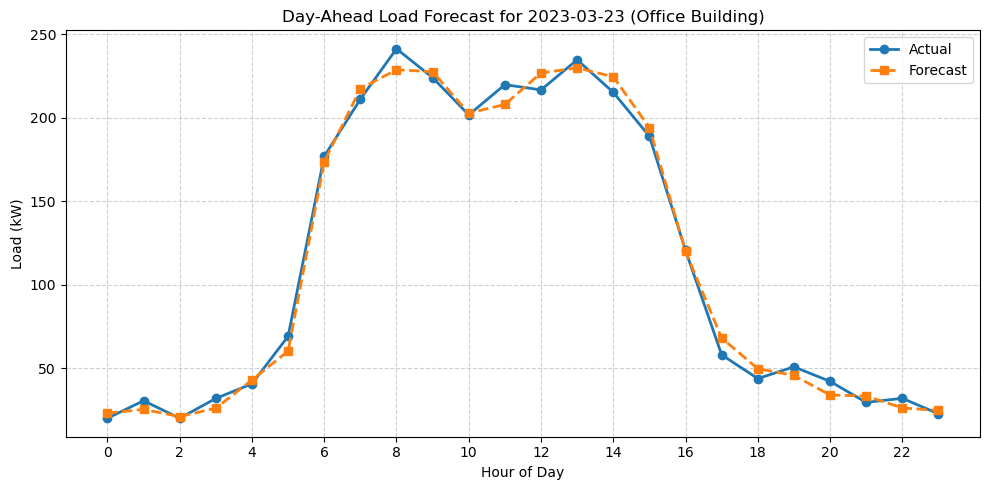


Overall MAE: 6.89 kW


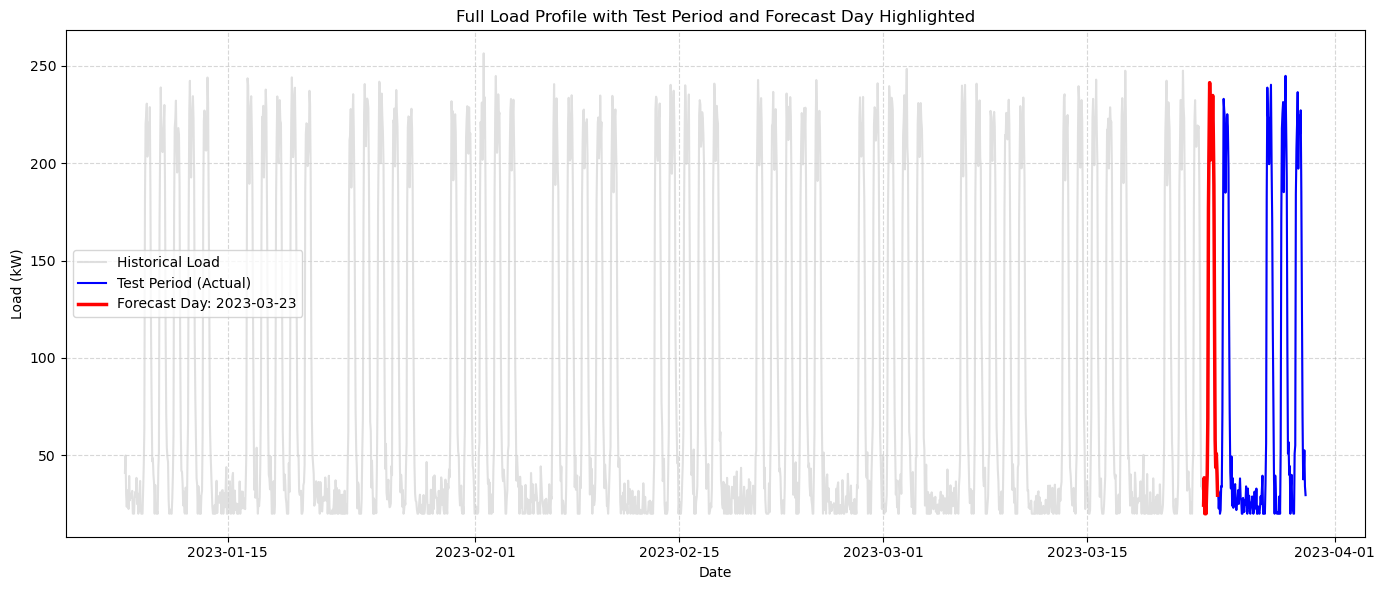

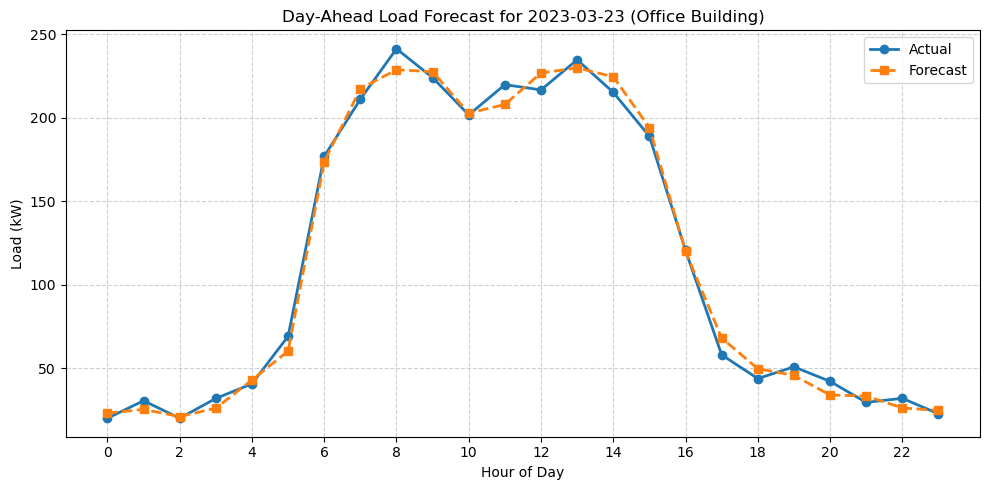

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

# ----------------------------
# 1. Generate Simulated Data
# ----------------------------
np.random.seed(42)
dates = pd.date_range(start='2023-01-01', end='2023-03-31', freq='H')
df = pd.DataFrame({'datetime': dates})
df.set_index('datetime', inplace=True)

# Base profile (weekday)
base_profile = np.array([
    30,25,20,20,20,25,40,60,180,220,230,225,
    200,210,225,230,220,190,120,70,50,40,35,30
])

# Weekend profile
weekend_profile = np.tile(25, 24)

def get_load(hour, dayofweek, temp):
    if dayofweek >= 5:  # Sat=5, Sun=6
        base = weekend_profile[hour]
    else:
        base = base_profile[hour]
    # Add temperature effect: +2 kW per °C above 22°C (cooling)
    temp_effect = max(0, temp - 22) * 2
    noise = np.random.normal(0, 8)
    return max(20, base + temp_effect + noise)

# Add temperature (seasonal + noise)
df['temp'] = 10 + 15 * np.sin(2 * np.pi * (df.index.dayofyear - 80) / 365) + np.random.normal(0, 3, len(df))
df['load'] = [get_load(dt.hour, dt.dayofweek, temp) for dt, temp in zip(df.index, df['temp'])]

# ----------------------------
# 2. Feature Engineering
# ----------------------------
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

# Lag features: load from same hour yesterday
df['load_lag24'] = df['load'].shift(24)

# Rolling avg
df['load_rolling_7d'] = df['load'].rolling(window=24*7).mean()

# Create target: next 24 hours (for day-ahead)
horizon = 24
for h in range(1, horizon + 1):
    df[f'target_h{h}'] = df['load'].shift(-h)

# Drop rows with NaN (first 7 days + last day)
df.dropna(inplace=True)

# ----------------------------
# 3. Prepare Features & Targets
# ----------------------------
feature_cols = ['hour', 'dayofweek', 'is_weekend', 'temp', 'load_lag24', 'load_rolling_7d']
X = df[feature_cols]
y = df[[f'target_h{h}' for h in range(1, 25)]]  # 24 targets

# Train-test split (last 7 days as test)
split_idx = len(X) - 24*7
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# ----------------------------
# 4. Train Model
# ----------------------------
model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# Train one model per hour (simple and effective)
models = {}
y_pred = pd.DataFrame(index=y_test.index, columns=y_test.columns)

for h in range(1, 25):
    print(f"Training model for hour +{h}...")
    model_h = xgb.XGBRegressor(n_estimators=150, max_depth=5, random_state=42)
    model_h.fit(X_train, y_train[f'target_h{h}'])
    y_pred[f'target_h{h}'] = model_h.predict(X_test)

# ----------------------------
# 5. Evaluate & Plot
# ----------------------------
mae = mean_absolute_error(y_test.values.flatten(), y_pred.values.flatten())
print(f"\nOverall MAE: {mae:.2f} kW")

# Plot forecast for next day (first day in test set)
forecast_day = y_test.index[0].date()
actual = y_test.iloc[0].values
predicted = y_pred.iloc[0].values
hours = np.arange(24)

plt.figure(figsize=(10, 5))
plt.plot(hours, actual, 'o-', label='Actual', linewidth=2)
plt.plot(hours, predicted, 's--', label='Forecast', linewidth=2)
plt.title(f'Day-Ahead Load Forecast for {forecast_day} (Office Building)')
plt.xlabel('Hour of Day')
plt.ylabel('Load (kW)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(hours[::2])
plt.tight_layout()
plt.show()


# ----------------------------
# 5. Evaluate & Plot
# ----------------------------
mae = mean_absolute_error(y_test.values.flatten(), y_pred.values.flatten())
print(f"\nOverall MAE: {mae:.2f} kW")

# Reconstruct full load series (original 'load' column, aligned with y_test index)
# Note: df['load'] exists and covers all dates before dropping NaNs
# But after dropna(), the index of df matches X and y
full_load = df['load']  # This includes train + test (after NaN drop)

# Plot 1: Full load profile (train + test)
plt.figure(figsize=(14, 6))
plt.plot(full_load.index, full_load.values, label='Historical Load', color='lightgray', alpha=0.7)

# Highlight test period
test_load = full_load.loc[X_test.index]
plt.plot(test_load.index, test_load.values, label='Test Period (Actual)', color='blue', linewidth=1.5)

# Highlight the forecast day (first day of test set)
forecast_day = y_test.index[0].date()
forecast_day_end = pd.Timestamp(forecast_day) + pd.Timedelta(days=1) - pd.Timedelta(hours=1)
day_mask = (full_load.index.date == forecast_day)
plt.plot(full_load.index[day_mask], full_load.loc[day_mask], 
         label=f'Forecast Day: {forecast_day}', color='red', linewidth=2.5)

plt.title('Full Load Profile with Test Period and Forecast Day Highlighted')
plt.xlabel('Date')
plt.ylabel('Load (kW)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot 2: Detailed forecast vs actual for the forecast day (as before, but improved)
actual = y_test.iloc[0].values
predicted = y_pred.iloc[0].values
hours = np.arange(24)

plt.figure(figsize=(10, 5))
plt.plot(hours, actual, 'o-', label='Actual', linewidth=2, markersize=6)
plt.plot(hours, predicted, 's--', label='Forecast', linewidth=2, markersize=6)
plt.title(f'Day-Ahead Load Forecast for {forecast_day} (Office Building)')
plt.xlabel('Hour of Day')
plt.ylabel('Load (kW)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(hours[::2])
plt.tight_layout()
plt.show()


📊 Algorithm Comparison (Office Building Load Forecasting)
                     MAE    RMSE    MAPE
Persistence        86.33  118.93  173.89
Linear Regression  53.19   64.42  122.08
Random Forest       6.38    8.03   14.67
XGBoost             6.79    8.68   15.63
LightGBM            6.44    8.28   14.61

🏆 Best model (lowest MAE): Random Forest

MAE by model:
  Persistence: 86.33 kW
  Linear Regression: 53.19 kW
  Random Forest: 6.38 kW
  XGBoost: 6.79 kW
  LightGBM: 6.44 kW


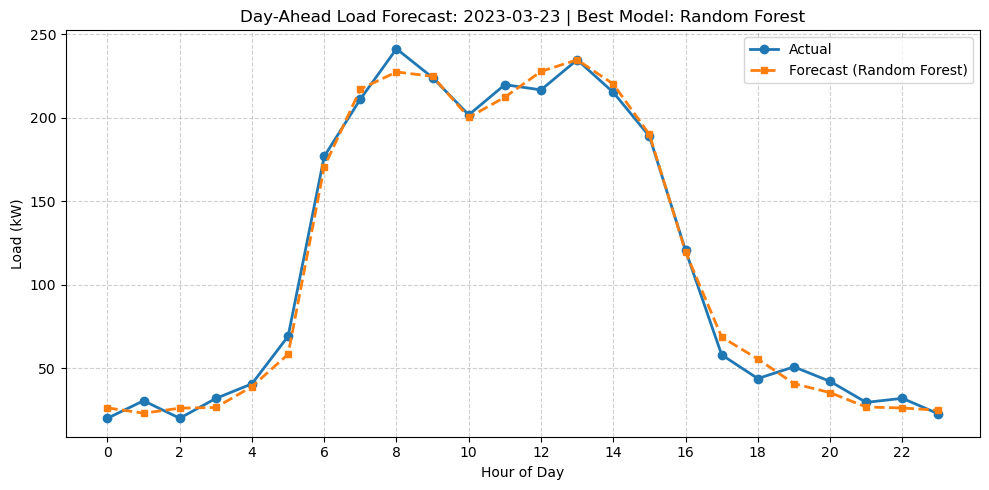

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
import lightgbm as lgb

# ----------------------------
# 1. Generate Simulated Office Load Data
# ----------------------------
np.random.seed(42)
dates = pd.date_range(start='2023-01-01', end='2023-03-31', freq='H')
df = pd.DataFrame({'datetime': dates})
df.set_index('datetime', inplace=True)

# Base weekday load profile (kW)
base_profile = np.array([
    30,25,20,20,20,25,40,60,180,220,230,225,
    200,210,225,230,220,190,120,70,50,40,35,30
])
weekend_profile = np.full(24, 25)

def get_load(hour, dayofweek, temp):
    base = weekend_profile[hour] if dayofweek >= 5 else base_profile[hour]
    temp_effect = max(0, temp - 22) * 2  # Cooling load
    noise = np.random.normal(0, 8)
    return max(20, base + temp_effect + noise)

# Add temperature (seasonal sine wave + noise)
df['temp'] = 10 + 15 * np.sin(2 * np.pi * (df.index.dayofyear - 80) / 365) + np.random.normal(0, 3, len(df))
df['load'] = [get_load(dt.hour, dt.dayofweek, temp) for dt, temp in zip(df.index, df['temp'])]

# ----------------------------
# 2. Feature Engineering
# ----------------------------
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
df['load_lag24'] = df['load'].shift(24)
df['load_rolling_7d'] = df['load'].rolling(window=24*7).mean()

# Create 24-hour ahead targets
horizon = 24
for h in range(1, horizon + 1):
    df[f'target_h{h}'] = df['load'].shift(-h)

df.dropna(inplace=True)

# ----------------------------
# 3. Prepare Train/Test Sets
# ----------------------------
feature_cols = ['hour', 'dayofweek', 'is_weekend', 'temp', 'load_lag24', 'load_rolling_7d']
X = df[feature_cols]
y = df[[f'target_h{h}' for h in range(1, 25)]]

# Use last 7 days for testing
split_idx = len(X) - 24 * 7
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# ----------------------------
# 4. Evaluation Helper
# ----------------------------
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1, None))) * 100

results = {}

# ----------------------------
# 5. Benchmark Models (Prophet REMOVED)
# ----------------------------

# (1) Persistence
y_persist = np.tile(X_test['load_lag24'].values.reshape(-1, 1), (1, 24))
results['Persistence'] = {
    'MAE': mean_absolute_error(y_test, y_persist),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_persist)),
    'MAPE': mape(y_test.values, y_persist)
}

# (2) Linear Regression
lr = MultiOutputRegressor(LinearRegression())
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results['Linear Regression'] = {
    'MAE': mean_absolute_error(y_test, y_pred_lr),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    'MAPE': mape(y_test.values, y_pred_lr)
}

# (3) Random Forest
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results['Random Forest'] = {
    'MAE': mean_absolute_error(y_test, y_pred_rf),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'MAPE': mape(y_test.values, y_pred_rf)
}

# (4) XGBoost
xgb_model = MultiOutputRegressor(xgb.XGBRegressor(n_estimators=150, max_depth=6, random_state=42))
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
results['XGBoost'] = {
    'MAE': mean_absolute_error(y_test, y_pred_xgb),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    'MAPE': mape(y_test.values, y_pred_xgb)
}

# (5) LightGBM
lgb_model = MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=150, max_depth=6, random_state=42))
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
results['LightGBM'] = {
    'MAE': mean_absolute_error(y_test, y_pred_lgb),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lgb)),
    'MAPE': mape(y_test.values, y_pred_lgb)
}

# ----------------------------
# 6. Display Results
# ----------------------------
results_df = pd.DataFrame(results).T
results_df = results_df.round(2)
print("\n📊 Algorithm Comparison (Office Building Load Forecasting)")
print("="*60)
print(results_df.to_string())

# Identify best model by MAE
best_model = results_df['MAE'].idxmin()
print(f"\n🏆 Best model (lowest MAE): {best_model}")

# Optional: Print MAEs for clarity
print("\nMAE by model:")
for model in results:
    print(f"  {model}: {results[model]['MAE']:.2f} kW")

# ----------------------------
# 7. Plot Best Model Forecast
# ----------------------------
# Select predictions from the best model
if best_model == 'XGBoost':
    y_best = y_pred_xgb
elif best_model == 'LightGBM':
    y_best = y_pred_lgb
elif best_model == 'Random Forest':
    y_best = y_pred_rf
elif best_model == 'Linear Regression':
    y_best = y_pred_lr
else:  # Persistence
    y_best = y_persist

# Get first day of test set
forecast_day = y_test.index[0].date()
actual = y_test.iloc[0].values
predicted = y_best[0]  # First row = forecast for first test day

# Plot
plt.figure(figsize=(10, 5))
plt.plot(actual, 'o-', label='Actual', linewidth=2, markersize=6)
plt.plot(predicted, 's--', label=f'Forecast ({best_model})', linewidth=2, markersize=5)
plt.title(f'Day-Ahead Load Forecast: {forecast_day} | Best Model: {best_model}')
plt.xlabel('Hour of Day')
plt.ylabel('Load (kW)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(ticks=range(0, 24, 2), labels=range(0, 24, 2))
plt.tight_layout()
plt.show()